## Grid transformations

In [1]:
import pathlib
import numpy as np
import pandas as pd
import xarray as xr
import xrft
import pyproj
import pygmt

import ensaio
import verde as vd
import boule as bl
import harmonica as hm

import matplotlib.pyplot as plt

In [2]:
figsdir = pathlib.Path("..") / "poster" / "figs"

Configure PyGMT plots

In [3]:
dark_mode = True
plot_frame_labels = False

if dark_mode:
    color = "white"
else:
    color = "black"

if plot_frame_labels:
    frame = "af"
else:
    frame = "f"
    
pygmt.config(
    FONT_ANNOT=f"11p,Helvetica,{color}",
    FONT_TITLE=f"12p,Helvetica,{color}",
    FONT_LABEL=f"10p,Helvetica,{color}",
    MAP_TITLE_OFFSET="0p",
    MAP_FRAME_WIDTH="2p",
)

In [4]:
fname = ensaio.fetch_lightning_creek_magnetic(version=1)
magnetic_grid = xr.load_dataarray(fname)
magnetic_grid

<xarray.DataArray 'total_field_anomaly' (northing: 370, easting: 346)>
array([[  35.        ,   36.19995   ,   36.69995   , ..., -101.099976  ,
        -100.400024  ,  -99.599976  ],
       [  36.5       ,   37.599976  ,   38.        , ..., -102.20007   ,
        -101.5       , -100.70007   ],
       [  37.099976  ,   38.19995   ,   38.599976  , ..., -103.30005   ,
        -102.599976  , -101.900024  ],
       ...,
       [ 182.79993   ,  172.40002   ,  160.79993   , ...,    0.79992676,
         -24.200073  ,  -41.80005   ],
       [ 182.09998   ,  172.59998   ,  161.40002   , ...,    6.        ,
         -21.5       ,  -41.        ],
       [ 178.79993   ,  170.40002   ,  160.29993   , ...,   11.400024  ,
         -16.        ,  -35.80005   ]], dtype=float32)
Coordinates:
  * easting   (easting) float64 4.655e+05 4.656e+05 ... 4.827e+05 4.828e+05
  * northing  (northing) float64 7.576e+06 7.576e+06 ... 7.595e+06 7.595e+06
    height    (northing, easting) float64 500.0 500.0 500.0 ... 500.0 500.0
Attributes:
    Conventions:   CF-1.8
    title:         Magnetic total-field anomaly of the Lightning Creek sill c...
    crs:           proj=utm zone=54 south datum=WGS84 units=m no_defs ellps=W...
    source:        Interpolated from airborne magnetic line data using gradie...
    license:       Creative Commons Attribution 4.0 International Licence
    references:    Geophysical Acquisition & Processing Section 2019. MIM Dat...
    long_name:     total-field magnetic anomaly
    units:         nT
    actual_range:  [-1785.  3798.]

In [5]:
projection = pyproj.Proj(proj="utm", zone=54, south=True, ellps="WGS84")
projection

<Other Coordinate Operation Transformer: utm>
Description: PROJ-based coordinate operation
Area of Use:
- undefined

In [6]:
easting, northing = np.meshgrid(magnetic_grid.easting, magnetic_grid.northing)
longitude, latitude = projection(easting, northing, inverse=True)
region_degrees = vd.get_region((longitude, latitude))
region_degrees

(140.66628415542823,
 140.83349563468775,
 -21.916835241161145,
 -21.749892896824395)

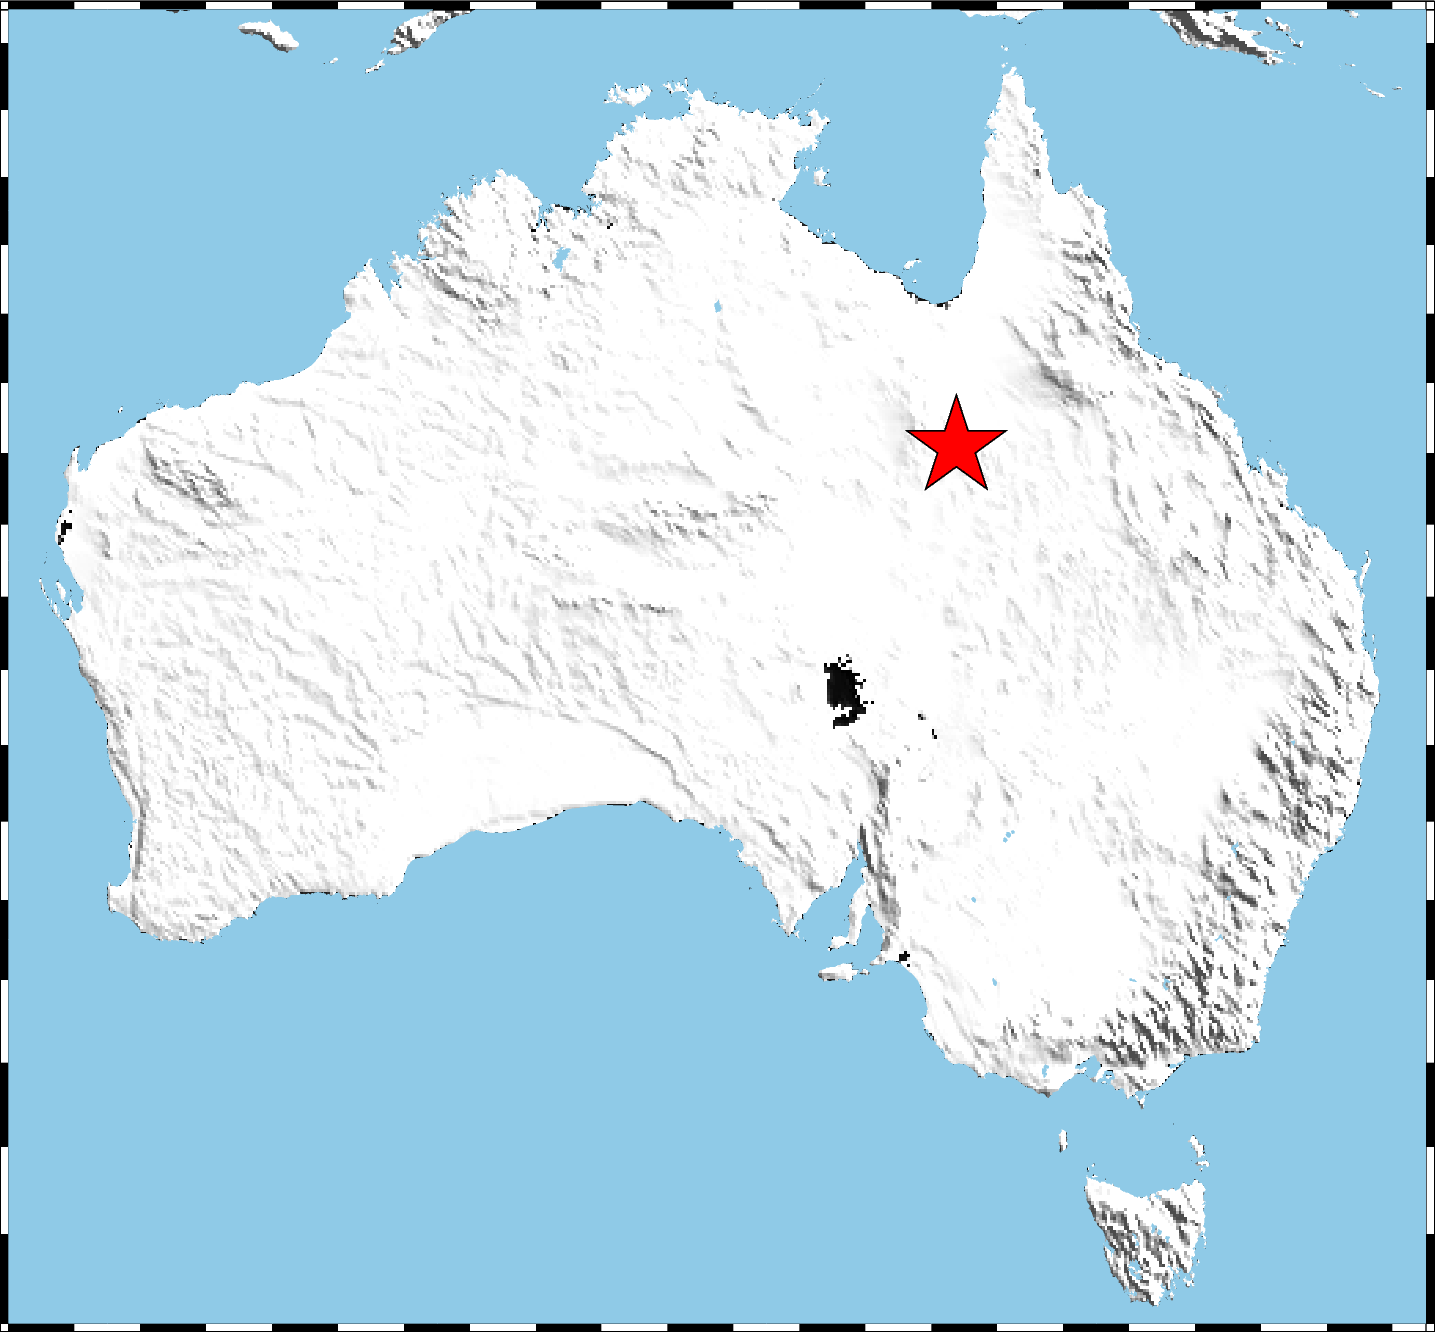

In [33]:
region_degrees_pad = (112, 155, -44, -9)
west, east, south, north = region_degrees[:]
lon_center, lat_center = np.mean([west, east]), np.mean([south, north])

fig = pygmt.Figure()
gmt_projection = "M12c"

pygmt.makecpt(cmap="gray")
fig.grdimage(
    "@earth_relief_05m",
    region=region_degrees_pad,
    projection=gmt_projection,
    shading="+a45+nt1.7",
    frame=frame,
    cmap=True,
)
fig.coast(
    water="#8fcae7",
    transparency=50,
)

fig.plot(x=[lon_center], y=[lat_center], projection=gmt_projection, style="a25p", fill="red", pen="black")
# fig.text(text="Lightning Creek Sill Complex", x=lon_center, y=lat_center - 1.6, font="14p,black")

fig.savefig(figsdir / "lightning-creek-location-map.png", dpi=300, transparent=True)
fig.show()

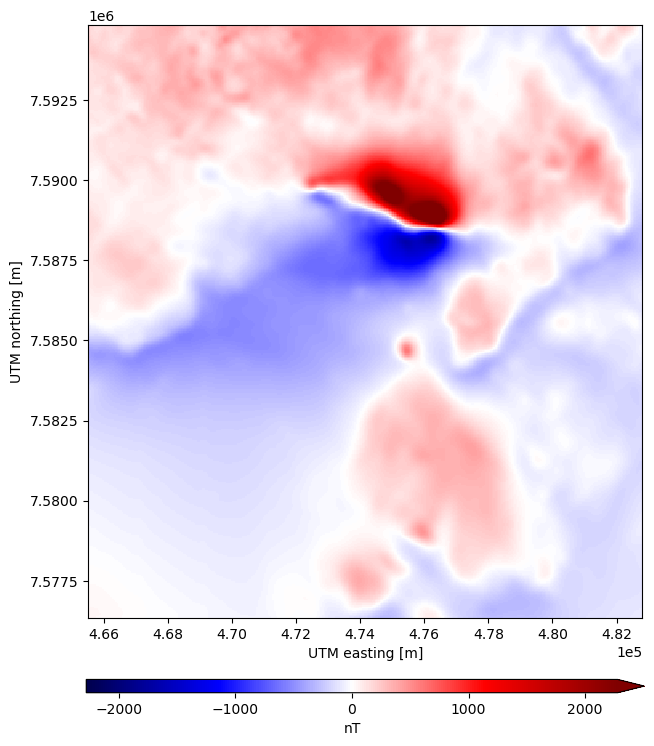

In [8]:
scale = vd.maxabs(magnetic_grid) * 0.6

plt.figure(figsize=(12, 10))
tmp = magnetic_grid.plot(cmap="seismic", vmin=-scale, vmax=scale, add_colorbar=False)
plt.gca().set_aspect("equal")
plt.ticklabel_format(style="sci", scilimits=(0,0))
plt.colorbar(tmp, label="nT", orientation="horizontal", shrink=0.6, aspect=42, pad=0.08, extend="max")
# plt.savefig(figsdir / "lightning-creek-tf-anomaly.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [9]:
magnetic_grid_deg = vd.project_grid(magnetic_grid, projection=lambda e,n: projection(e, n, inverse=True))
magnetic_grid_deg = magnetic_grid_deg.rename(easting="longitude", northing="latitude")
magnetic_grid_deg

<xarray.DataArray 'total_field_anomaly' (latitude: 370, longitude: 346)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,   36.61411233,   37.21759459, ..., -101.92299206,
        -101.21709941,           nan],
       [          nan,   37.73400147,   38.19291538, ..., -103.0456831 ,
        -102.32625637,           nan],
       ...,
       [          nan,  180.57242421,  169.62749393, ...,    3.76530149,
         -19.59604924,           nan],
       [          nan,  179.28248042,  169.64067115, ...,    9.12508569,
         -15.81840669,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * longitude  (longitude) float64 140.7 140.7 140.7 140.7 ... 140.8 140.8 140.8
  * latitude   (latitude) float64 -21.92 -21.92 -21.92 ... -21.75 -21.75 -21.75
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

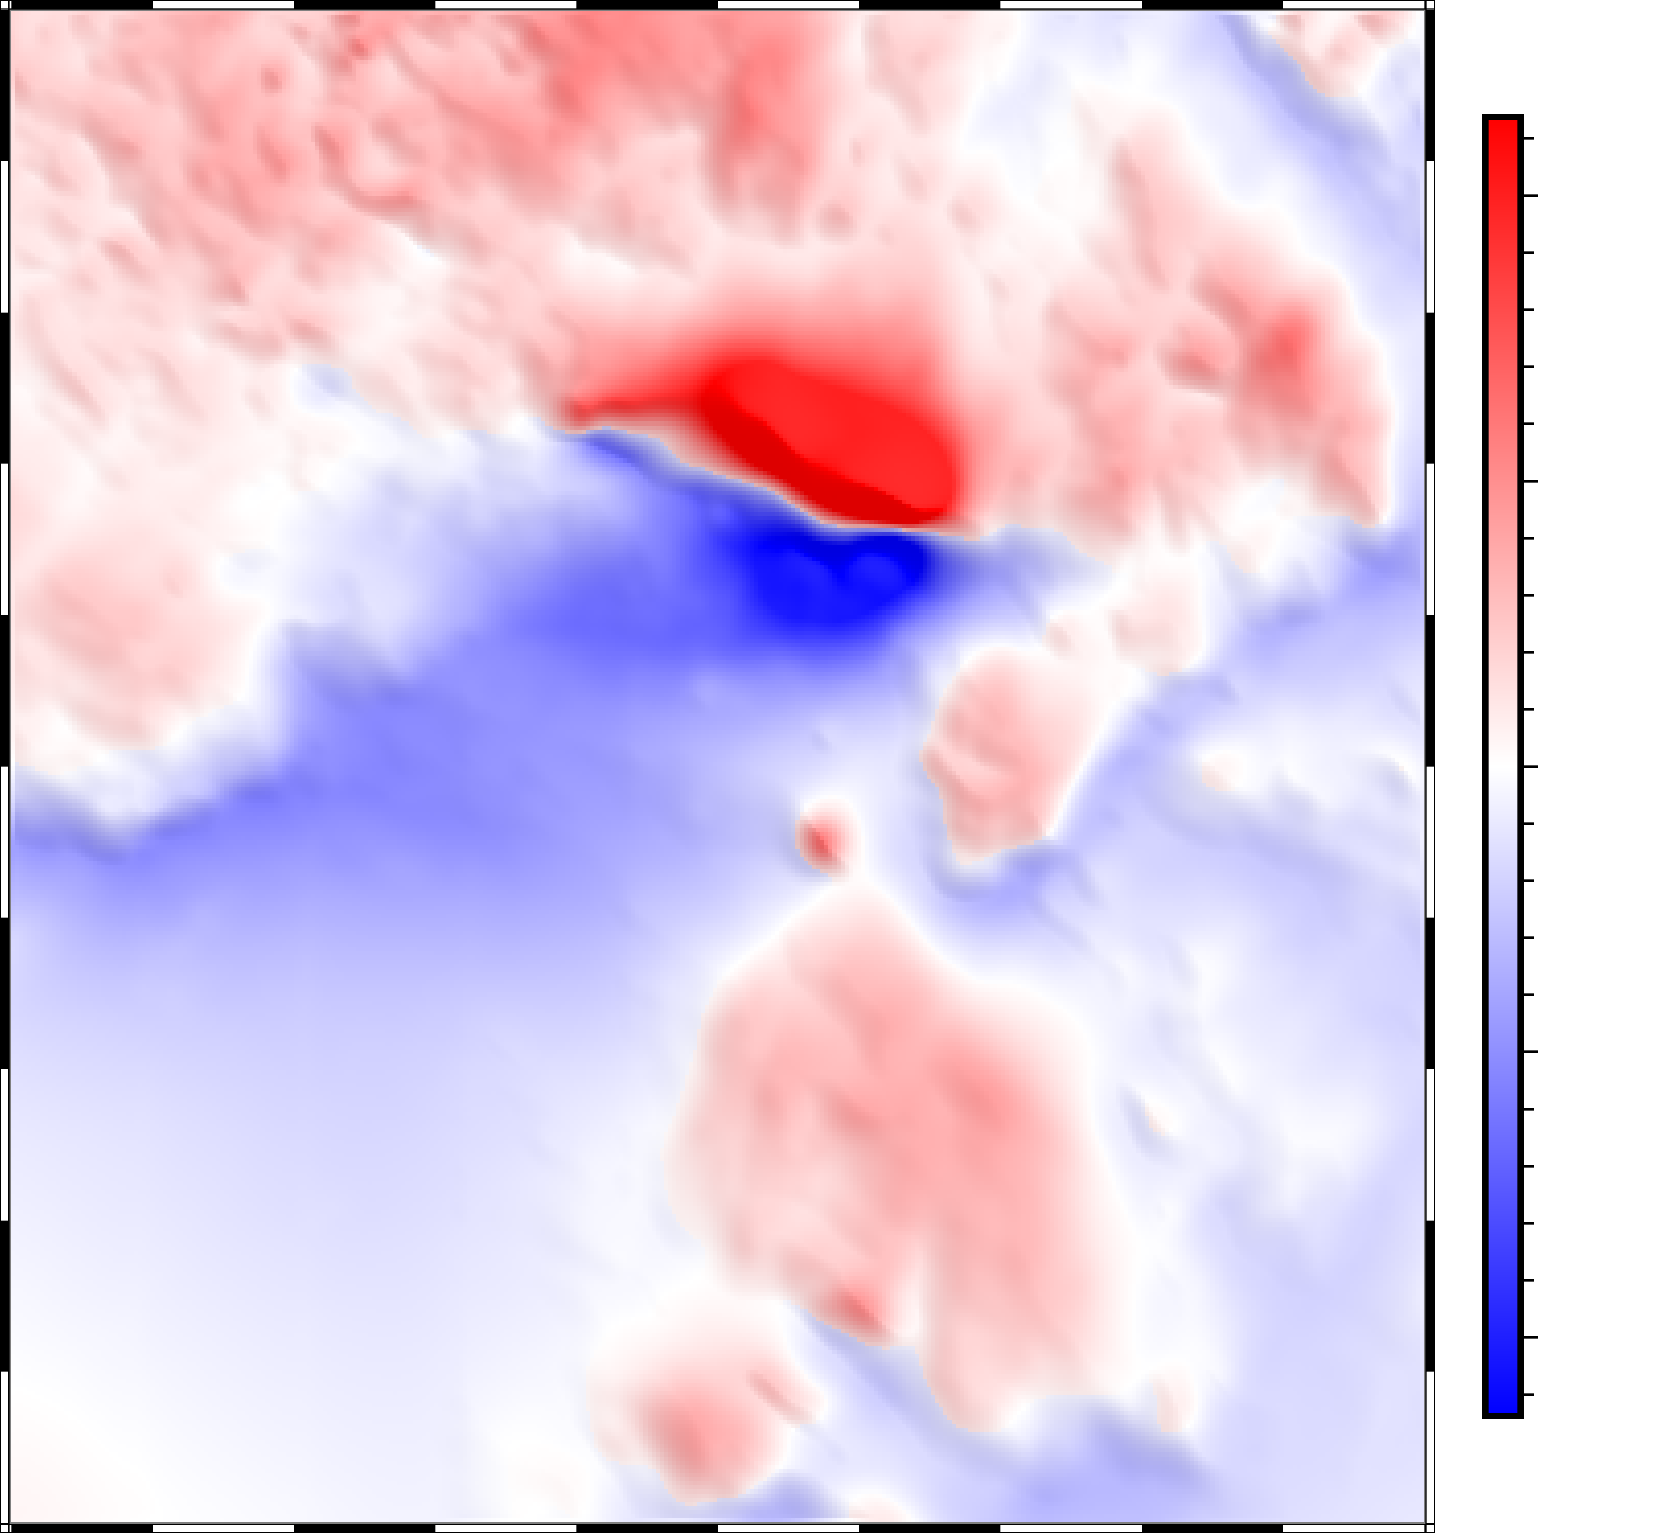

In [10]:
fig = pygmt.Figure()

maxabs = vd.maxabs(magnetic_grid_deg) * 0.3

pygmt.makecpt(
    cmap="polar",
    series=[-maxabs, maxabs],
    background=True,
)
fig.grdimage(
    magnetic_grid_deg,
    projection=gmt_projection,
    shading="+a45+nt0.2",
    frame=frame,
)

fig.colorbar(position="JMR+o0.5c/0c+w11c/0.3c", frame=['af', 'y+l"nT"'])

fig.savefig(figsdir / "lightning-creek-mag-data.png", dpi=300, transparent=True)
fig.show()

## Pad magnetic grid

In [11]:
pad_width = {
    "easting": magnetic_grid.easting.size * 2,
    "northing": magnetic_grid.northing.size * 2,
}
magnetic_grid_no_height = magnetic_grid.drop_vars("height")
magnetic_grid_padded = xrft.pad(magnetic_grid_no_height, pad_width=pad_width)
magnetic_grid_padded

<xarray.DataArray 'total_field_anomaly' (northing: 1850, easting: 1730)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * easting   (easting) float64 4.309e+05 4.31e+05 ... 5.173e+05 5.174e+05
  * northing  (northing) float64 7.539e+06 7.539e+06 ... 7.632e+06 7.632e+06
Attributes:
    Conventions:   CF-1.8
    title:         Magnetic total-field anomaly of the Lightning Creek sill c...
    crs:           proj=utm zone=54 south datum=WGS84 units=m no_defs ellps=W...
    source:        Interpolated from airborne magnetic line data using gradie...
    license:       Creative Commons Attribution 4.0 International Licence
    references:    Geophysical Acquisition & Processing Section 2019. MIM Dat...
    long_name:     total-field magnetic anomaly
    units:         nT
    actual_range:  [-1785.  3798.]

## Reduction to the pole

In [12]:
inclination, declination = -52.98, 6.51

In [13]:
rtp_grid = hm.reduction_to_pole(
    magnetic_grid_padded, inclination=inclination, declination=declination
)

# Unpad the reduced to the pole grid
rtp_grid = xrft.unpad(rtp_grid, pad_width)
rtp_grid

<xarray.DataArray (northing: 370, easting: 346)>
array([[  16.93705197,   13.21909213,   12.83890377, ..., -222.23901243,
        -213.42087047, -181.95752217],
       [  -0.6649667 ,   -6.75056907,   -8.34948274, ..., -167.62572332,
        -160.59818984, -135.85690628],
       [   0.44100267,   -6.63411214,   -8.55217998, ..., -173.28394383,
        -167.80590291, -143.67866746],
       ...,
       [  59.5174793 ,  -10.69762171,  -37.14385576, ...,  -35.48497238,
         -59.10510223,  -71.00981456],
       [  51.08851873,  -22.90653811,  -44.15507573, ...,  -29.73328996,
         -50.75866522,  -66.16979977],
       [ -88.21033532, -141.42147514, -151.68005749, ...,  -31.99345026,
         -30.03641906,  -35.16255006]])
Coordinates:
  * northing  (northing) float64 7.576e+06 7.576e+06 ... 7.595e+06 7.595e+06
  * easting   (easting) float64 4.655e+05 4.656e+05 ... 4.827e+05 4.828e+05

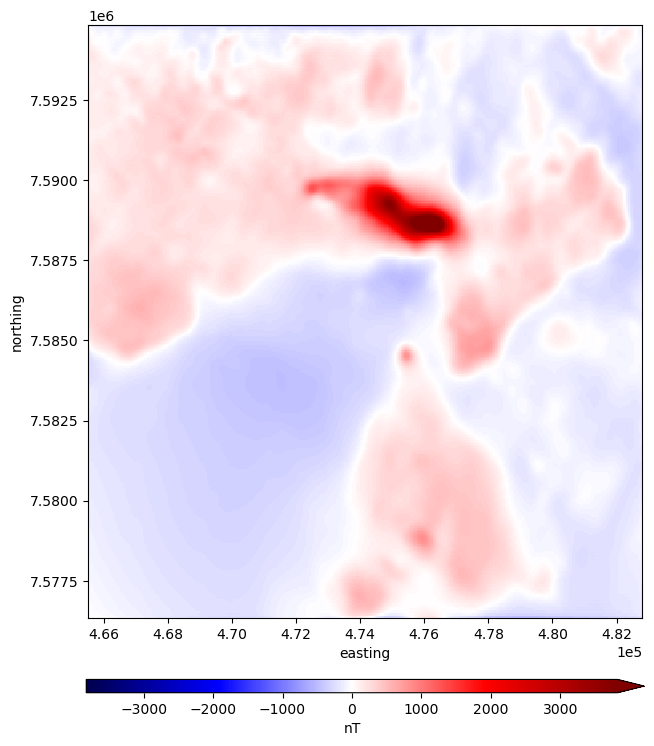

In [14]:
scale = vd.maxabs(rtp_grid) * 0.7

plt.figure(figsize=(12, 10))
tmp = rtp_grid.plot(cmap="seismic", vmin=-scale, vmax=scale, add_colorbar=False)
plt.gca().set_aspect("equal")
plt.ticklabel_format(style="sci", scilimits=(0,0))
plt.colorbar(tmp, label="nT", orientation="horizontal", shrink=0.6, aspect=42, pad=0.08, extend="max")
# plt.savefig(figsdir / "lightning-creek-rtp.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [15]:
rtp_grid_deg = vd.project_grid(rtp_grid, projection=lambda e,n: projection(e, n, inverse=True))
rtp_grid_deg = rtp_grid_deg.rename(easting="longitude", northing="latitude")
rtp_grid_deg

<xarray.DataArray 'scalars' (latitude: 370, longitude: 346)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,    5.00328978,    3.05531626, ..., -180.61903491,
        -170.77988271,           nan],
       [          nan,   -5.85675057,   -8.9143934 , ..., -166.88783587,
        -158.23107109,           nan],
       ...,
       [          nan,   46.93157871,   -8.39257124, ...,  -32.23655988,
         -51.81644914,           nan],
       [          nan,   -2.79744393,  -55.48864738, ...,  -31.00612309,
         -34.49597649,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * longitude  (longitude) float64 140.7 140.7 140.7 140.7 ... 140.8 140.8 140.8
  * latitude   (latitude) float64 -21.92 -21.92 -21.92 ... -21.75 -21.75 -21.75
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

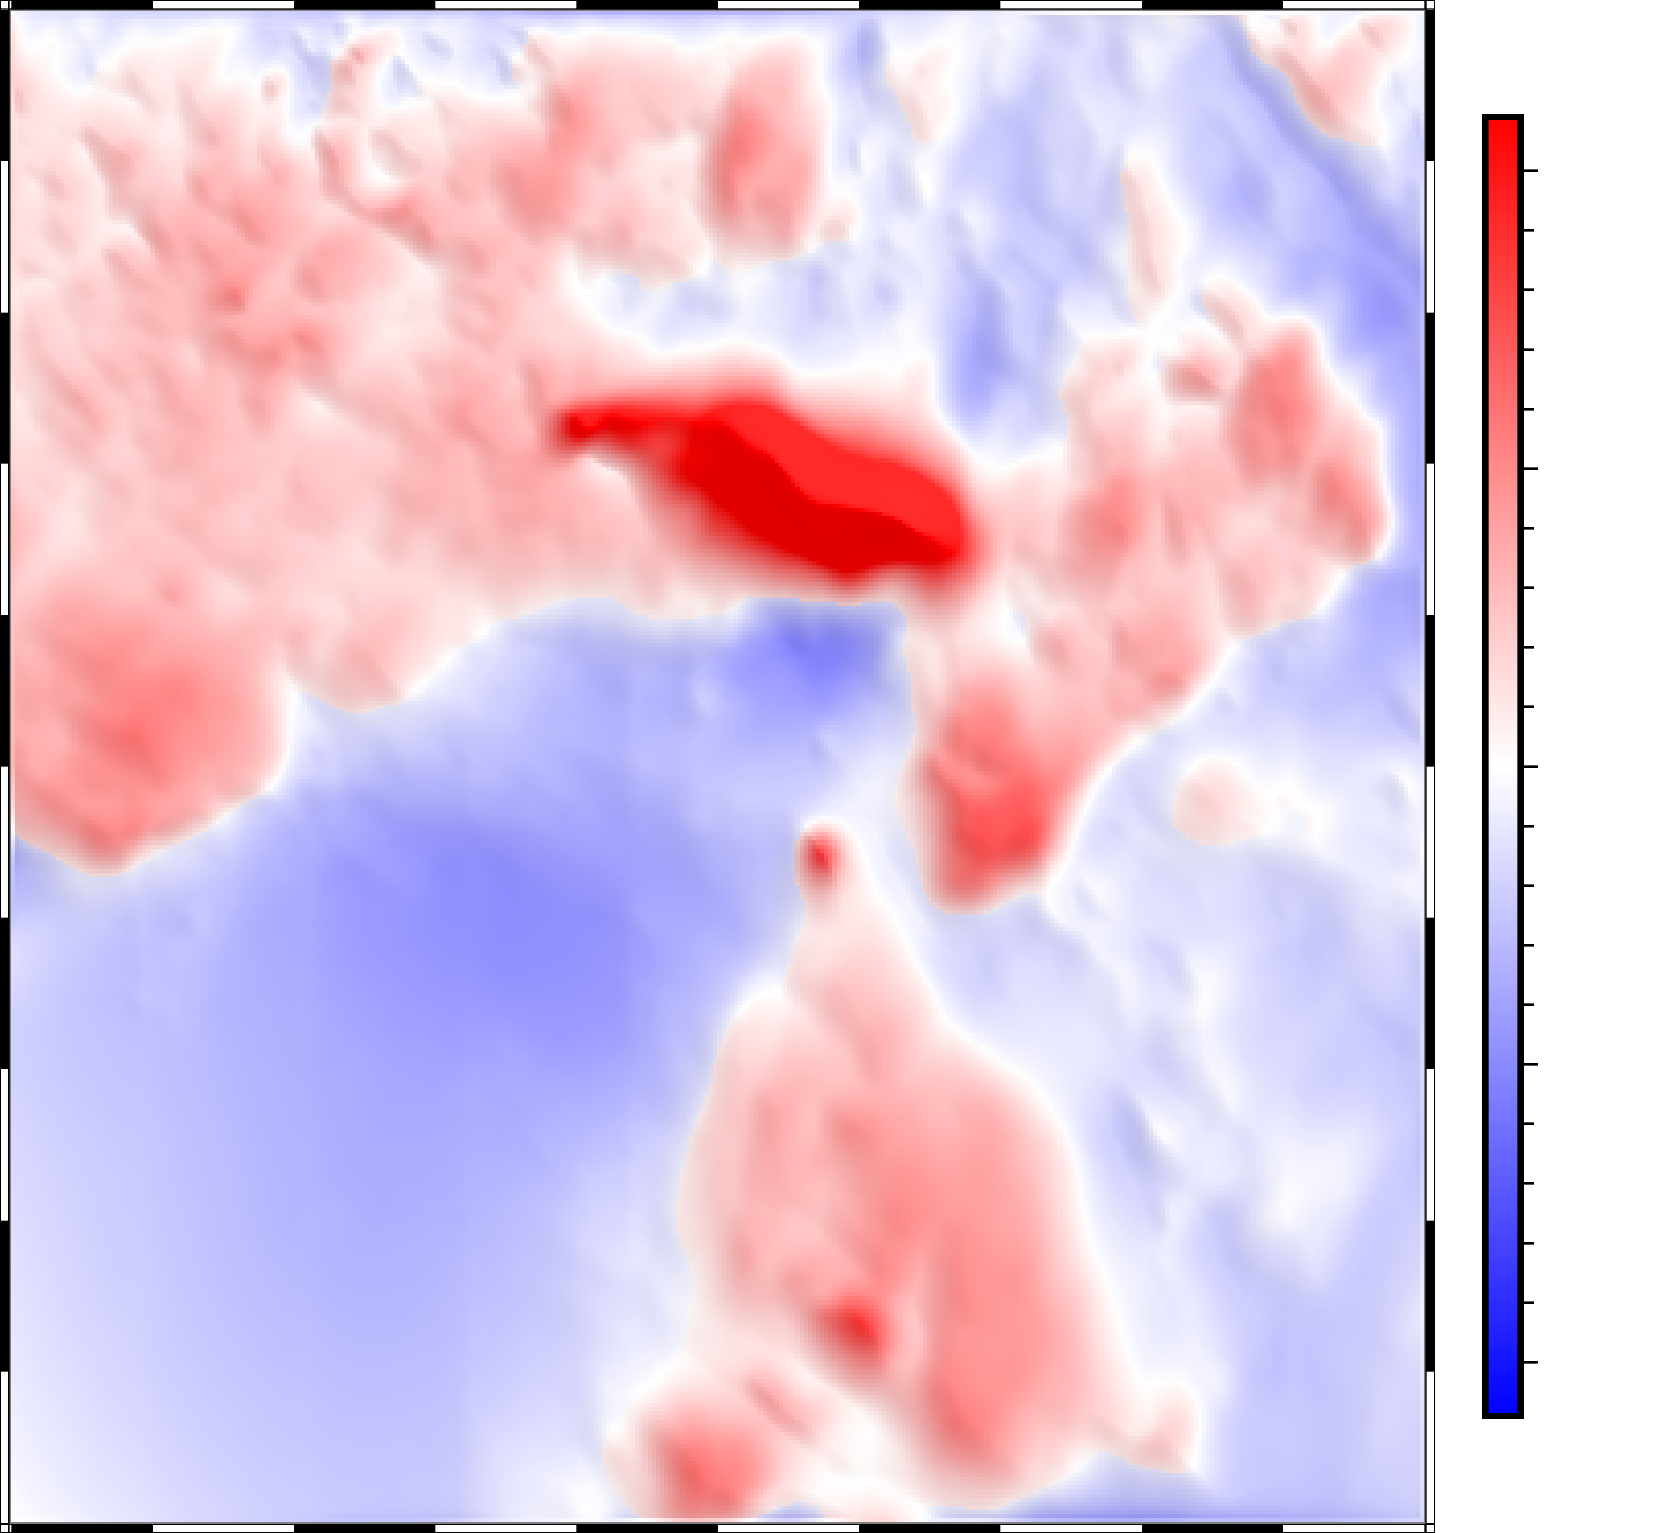

In [16]:
fig = pygmt.Figure()

maxabs = vd.maxabs(rtp_grid_deg) * 0.2

pygmt.makecpt(
    cmap="polar",
    series=[-maxabs, maxabs],
    background=True,
)
fig.grdimage(
    rtp_grid_deg,
    projection=gmt_projection,
    shading="+a45+nt0.2",
    frame=frame,
)

fig.colorbar(position="JMR+o0.5c/0c+w11c/0.3c", frame=['af', 'y+l"nT"'])

fig.savefig(figsdir / "lightning-creek-rtp.png", dpi=300, transparent=True)
fig.show()

## Upward derivative

In [17]:
grid_padded = xrft.pad(rtp_grid, pad_width)
deriv_upward = hm.derivative_upward(grid_padded)
deriv_upward = xrft.unpad(deriv_upward, pad_width)
deriv_upward

<xarray.DataArray (northing: 370, easting: 346)>
array([[ 8.07474200e-01,  5.46420314e-01,  6.55472379e-01, ...,
        -4.60766218e+00, -4.59828845e+00, -5.23539780e+00],
       [-5.62203705e-02, -2.50913265e-01, -1.75389319e-01, ...,
         4.16805564e-03, -2.11904779e-01, -1.33999129e+00],
       [ 2.93265451e-01,  1.07199062e-01,  2.06796571e-01, ...,
        -1.09331128e+00, -1.34957308e+00, -2.40063823e+00],
       ...,
       [ 1.65688041e+00, -9.97391466e-01, -5.81939665e-01, ...,
        -4.17968218e-01, -6.45092041e-01, -1.54012856e+00],
       [ 3.26382364e+00,  5.66704924e-01,  1.05990594e+00, ...,
        -1.61273728e-01, -5.82501438e-01, -1.70340763e+00],
       [-3.44598640e+00, -4.59266234e+00, -4.25068453e+00, ...,
        -6.63387956e-01, -2.89404739e-01, -7.89053874e-01]])
Coordinates:
  * northing  (northing) float64 7.576e+06 7.576e+06 ... 7.595e+06 7.595e+06
  * easting   (easting) float64 4.655e+05 4.656e+05 ... 4.827e+05 4.828e+05

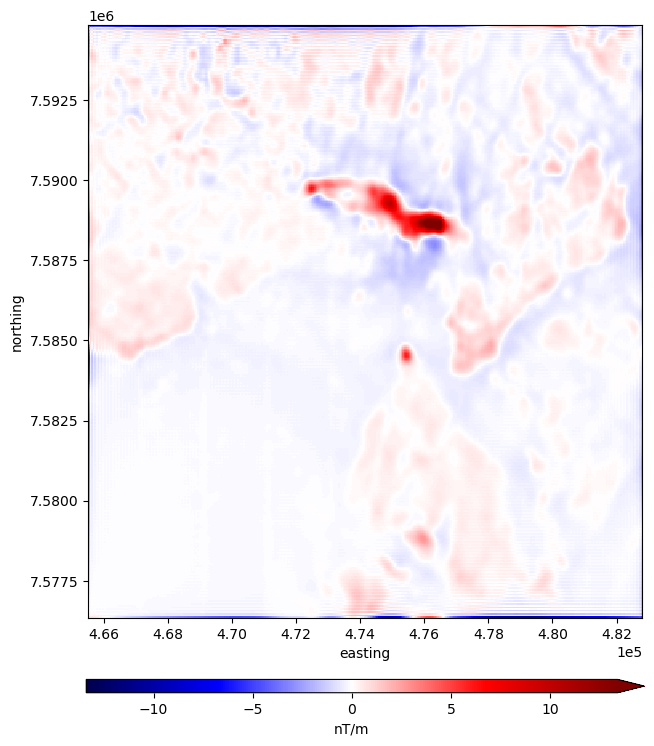

In [18]:
scale = vd.maxabs(deriv_upward) * 0.7

plt.figure(figsize=(12, 10))
tmp = deriv_upward.plot(cmap="seismic", vmin=-scale, vmax=scale, add_colorbar=False)
plt.gca().set_aspect("equal")
plt.ticklabel_format(style="sci", scilimits=(0,0))
plt.colorbar(tmp, label="nT/m", orientation="horizontal", shrink=0.6, aspect=42, pad=0.08, extend="max")
# plt.savefig(figsdir / "lightning-creek-rtp-deriv-upward.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

## Upward continuation

In [19]:
grid_padded = xrft.pad(rtp_grid, pad_width)
upward_cont = hm.upward_continuation(grid_padded, height_displacement=200)
upward_cont = xrft.unpad(upward_cont, pad_width)
upward_cont

<xarray.DataArray (northing: 370, easting: 346)>
array([[-11.68398048, -12.94269647, -14.36627369, ..., -66.26619004,
        -58.6570116 , -50.25363394],
       [-13.04467818, -14.60159835, -16.33679078, ..., -75.57808322,
        -66.70594596, -56.85237813],
       [-14.57591241, -16.46006775, -18.5198765 , ..., -82.78556377,
        -72.97866068, -62.0795687 ],
       ...,
       [  0.47199711,  -3.07096277,  -7.63101768, ...,   0.58145371,
         -2.45427101,  -3.86995249],
       [ -2.13131797,  -5.76496579, -10.09864624, ...,   0.25328768,
         -2.14775287,  -3.26567928],
       [ -3.59484029,  -6.97146992, -10.77083373, ...,   0.17403565,
         -1.60407697,  -2.45973689]])
Coordinates:
  * northing  (northing) float64 7.576e+06 7.576e+06 ... 7.595e+06 7.595e+06
  * easting   (easting) float64 4.655e+05 4.656e+05 ... 4.827e+05 4.828e+05

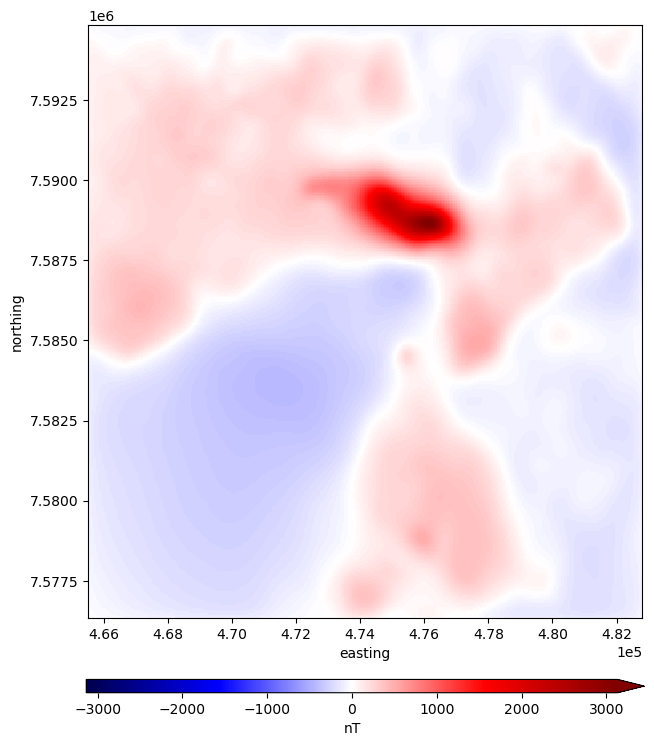

In [20]:
scale = vd.maxabs(upward_cont)

plt.figure(figsize=(12, 10))
tmp = upward_cont.plot(cmap="seismic", vmin=-scale, vmax=scale, add_colorbar=False)
plt.gca().set_aspect("equal")
plt.ticklabel_format(style="sci", scilimits=(0,0))
plt.colorbar(tmp, label="nT", orientation="horizontal", shrink=0.6, aspect=42, pad=0.08, extend="max")
# plt.savefig(figsdir / "lightning-creek-rtp-upward-cont.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [21]:
upward_cont_deg = vd.project_grid(upward_cont, projection=lambda e,n: projection(e, n, inverse=True))
upward_cont_deg = upward_cont_deg.rename(easting="longitude", northing="latitude")
upward_cont_deg

<xarray.DataArray 'scalars' (latitude: 370, longitude: 346)>
array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan, -13.78672909, -15.26351266, ..., -71.75481945,
        -61.90845725,          nan],
       [         nan, -15.45460246, -17.33289474, ..., -78.51797199,
        -68.67749888,          nan],
       ...,
       [         nan,  -0.18652571,  -3.72868835, ...,   0.41388409,
         -1.92188145,          nan],
       [         nan,  -2.52417306,  -6.27302275, ...,   0.22014865,
         -1.34188577,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])
Coordinates:
  * longitude  (longitude) float64 140.7 140.7 140.7 140.7 ... 140.8 140.8 140.8
  * latitude   (latitude) float64 -21.92 -21.92 -21.92 ... -21.75 -21.75 -21.75
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

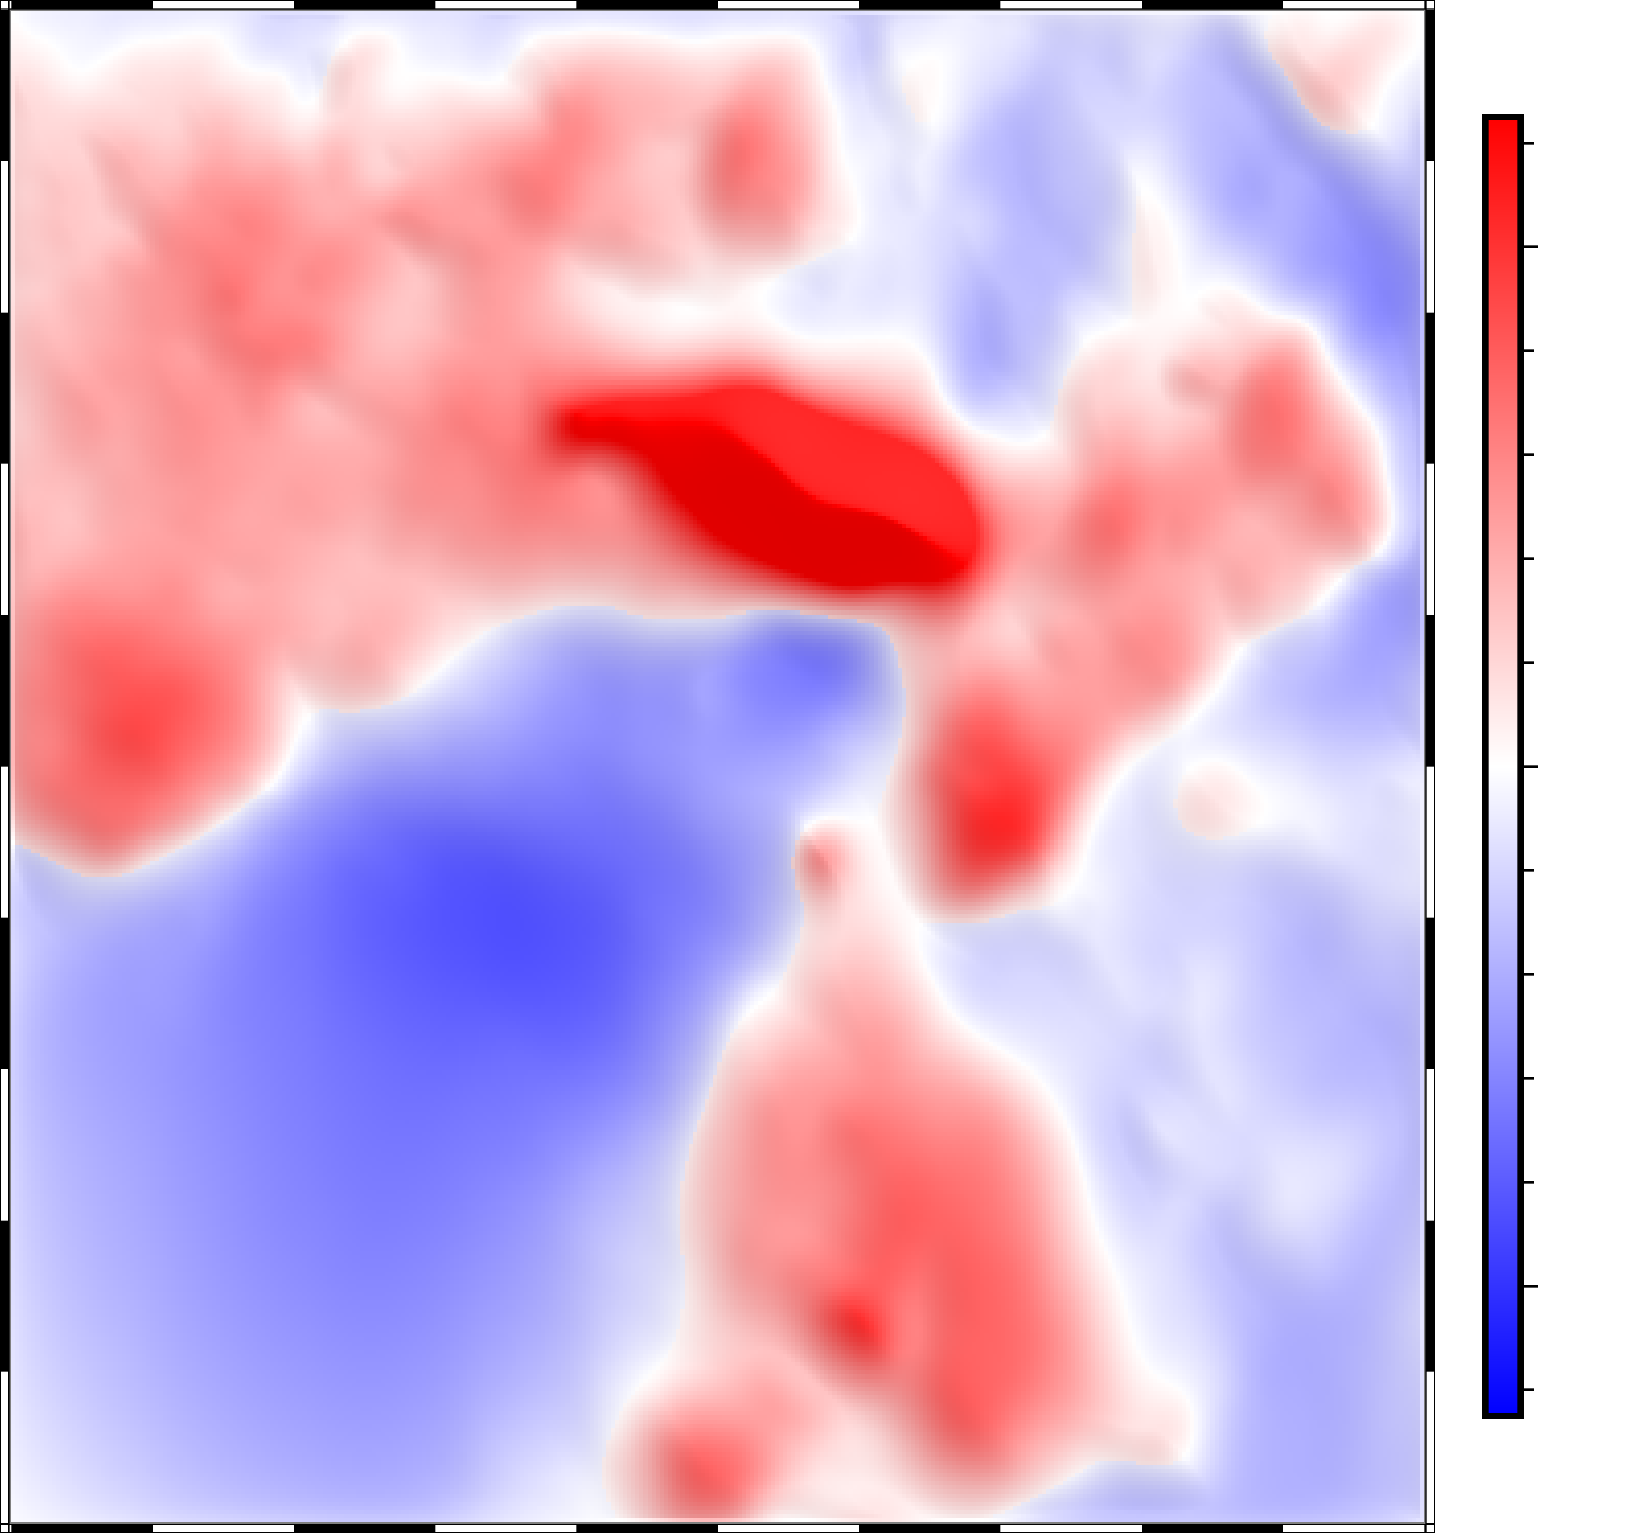

In [22]:
fig = pygmt.Figure()

maxabs = vd.maxabs(upward_cont_deg) * 0.2

pygmt.makecpt(
    cmap="polar",
    series=[-maxabs, maxabs],
    background=True,
)
fig.grdimage(
    upward_cont_deg,
    projection=gmt_projection,
    shading="+a45+nt0.2",
    frame=frame,
)

fig.colorbar(position="JMR+o0.5c/0c+w11c/0.3c", frame=['af', 'y+l"nT"'])

fig.savefig(figsdir / "lightning-creek-upward-cont.png", dpi=300, transparent=True)
fig.show()